# Afriat

In [1]:
ood_seed = 15

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('30', 'Periportal', 'Infected')


Removed datapoint: 307

train         14963
validation     3783
ood             307
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 48%|████▊     | 9173/19053 [00:00<00:00, 91718.28it/s]

 96%|█████████▋| 18382/19053 [00:00<00:00, 91932.21it/s]

100%|██████████| 19053/19053 [00:00<00:00, 91425.98it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1037252.40it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 324.77it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:10<1:12:31, 10.91s/it]

Epoch 1/400:   0%|          | 1/400 [00:10<1:12:31, 10.91s/it, v_num=1, recon=3.98e+3, r2_mean=0.205, adv_loss=3.28, acc_pert=0.274, acc_zone=0.736, acc_status_control=0.5]

Epoch 2/400:   0%|          | 1/400 [00:10<1:12:31, 10.91s/it, v_num=1, recon=3.98e+3, r2_mean=0.205, adv_loss=3.28, acc_pert=0.274, acc_zone=0.736, acc_status_control=0.5]

Epoch 2/400:   0%|          | 2/400 [00:21<1:09:42, 10.51s/it, v_num=1, recon=3.98e+3, r2_mean=0.205, adv_loss=3.28, acc_pert=0.274, acc_zone=0.736, acc_status_control=0.5]

Epoch 2/400:   0%|          | 2/400 [00:21<1:09:42, 10.51s/it, v_num=1, recon=3.26e+3, r2_mean=0.616, adv_loss=2.85, acc_pert=0.373, acc_zone=0.823, acc_status_control=0.634]

Epoch 3/400:   0%|          | 2/400 [00:21<1:09:42, 10.51s/it, v_num=1, recon=3.26e+3, r2_mean=0.616, adv_loss=2.85, acc_pert=0.373, acc_zone=0.823, acc_status_control=0.634]

Epoch 3/400:   1%|          | 3/400 [00:31<1:08:47, 10.40s/it, v_num=1, recon=3.26e+3, r2_mean=0.616, adv_loss=2.85, acc_pert=0.373, acc_zone=0.823, acc_status_control=0.634]

Epoch 3/400:   1%|          | 3/400 [00:31<1:08:47, 10.40s/it, v_num=1, recon=3.2e+3, r2_mean=0.717, adv_loss=2.73, acc_pert=0.404, acc_zone=0.832, acc_status_control=0.637] 

Epoch 4/400:   1%|          | 3/400 [00:31<1:08:47, 10.40s/it, v_num=1, recon=3.2e+3, r2_mean=0.717, adv_loss=2.73, acc_pert=0.404, acc_zone=0.832, acc_status_control=0.637]

Epoch 4/400:   1%|          | 4/400 [00:42<1:09:20, 10.51s/it, v_num=1, recon=3.2e+3, r2_mean=0.717, adv_loss=2.73, acc_pert=0.404, acc_zone=0.832, acc_status_control=0.637]

Epoch 4/400:   1%|          | 4/400 [00:42<1:09:20, 10.51s/it, v_num=1, recon=3.19e+3, r2_mean=0.759, adv_loss=2.64, acc_pert=0.461, acc_zone=0.829, acc_status_control=0.627]

Epoch 5/400:   1%|          | 4/400 [00:42<1:09:20, 10.51s/it, v_num=1, recon=3.19e+3, r2_mean=0.759, adv_loss=2.64, acc_pert=0.461, acc_zone=0.829, acc_status_control=0.627]

Epoch 5/400:   1%|▏         | 5/400 [00:52<1:08:00, 10.33s/it, v_num=1, recon=3.19e+3, r2_mean=0.759, adv_loss=2.64, acc_pert=0.461, acc_zone=0.829, acc_status_control=0.627]

Epoch 5/400:   1%|▏         | 5/400 [00:52<1:08:00, 10.33s/it, v_num=1, recon=3.17e+3, r2_mean=0.78, adv_loss=2.44, acc_pert=0.526, acc_zone=0.835, acc_status_control=0.633] 

Epoch 6/400:   1%|▏         | 5/400 [00:52<1:08:00, 10.33s/it, v_num=1, recon=3.17e+3, r2_mean=0.78, adv_loss=2.44, acc_pert=0.526, acc_zone=0.835, acc_status_control=0.633]

Epoch 6/400:   2%|▏         | 6/400 [01:02<1:07:46, 10.32s/it, v_num=1, recon=3.17e+3, r2_mean=0.78, adv_loss=2.44, acc_pert=0.526, acc_zone=0.835, acc_status_control=0.633]

Epoch 6/400:   2%|▏         | 6/400 [01:02<1:07:46, 10.32s/it, v_num=1, recon=3.16e+3, r2_mean=0.792, adv_loss=2.27, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.643]

Epoch 7/400:   2%|▏         | 6/400 [01:02<1:07:46, 10.32s/it, v_num=1, recon=3.16e+3, r2_mean=0.792, adv_loss=2.27, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.643]

Epoch 7/400:   2%|▏         | 7/400 [01:12<1:07:10, 10.26s/it, v_num=1, recon=3.16e+3, r2_mean=0.792, adv_loss=2.27, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.643]

Epoch 7/400:   2%|▏         | 7/400 [01:12<1:07:10, 10.26s/it, v_num=1, recon=3.15e+3, r2_mean=0.803, adv_loss=2.21, acc_pert=0.59, acc_zone=0.841, acc_status_control=0.642]

Epoch 8/400:   2%|▏         | 7/400 [01:12<1:07:10, 10.26s/it, v_num=1, recon=3.15e+3, r2_mean=0.803, adv_loss=2.21, acc_pert=0.59, acc_zone=0.841, acc_status_control=0.642]

Epoch 8/400:   2%|▏         | 8/400 [01:22<1:06:58, 10.25s/it, v_num=1, recon=3.15e+3, r2_mean=0.803, adv_loss=2.21, acc_pert=0.59, acc_zone=0.841, acc_status_control=0.642]

Epoch 8/400:   2%|▏         | 8/400 [01:22<1:06:58, 10.25s/it, v_num=1, recon=3.14e+3, r2_mean=0.809, adv_loss=2.18, acc_pert=0.601, acc_zone=0.843, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 8/400 [01:22<1:06:58, 10.25s/it, v_num=1, recon=3.14e+3, r2_mean=0.809, adv_loss=2.18, acc_pert=0.601, acc_zone=0.843, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 9/400 [01:32<1:06:46, 10.25s/it, v_num=1, recon=3.14e+3, r2_mean=0.809, adv_loss=2.18, acc_pert=0.601, acc_zone=0.843, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 9/400 [01:32<1:06:46, 10.25s/it, v_num=1, recon=3.14e+3, r2_mean=0.814, adv_loss=2.15, acc_pert=0.612, acc_zone=0.842, acc_status_control=0.646]

Epoch 10/400:   2%|▏         | 9/400 [01:33<1:06:46, 10.25s/it, v_num=1, recon=3.14e+3, r2_mean=0.814, adv_loss=2.15, acc_pert=0.612, acc_zone=0.842, acc_status_control=0.646]


disnt_basal = 1.2603392256352208

disnt_after = 1.8651910760977435

val_r2_mean = 0.8141026897135614

val_r2_var = 0.18521048260510936


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [02:07<1:56:13, 17.88s/it, v_num=1, recon=3.14e+3, r2_mean=0.814, adv_loss=2.15, acc_pert=0.612, acc_zone=0.842, acc_status_control=0.646]

Epoch 10/400:   2%|▎         | 10/400 [02:07<1:56:13, 17.88s/it, v_num=1, recon=3.13e+3, r2_mean=0.817, adv_loss=2.11, acc_pert=0.626, acc_zone=0.85, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [02:07<1:56:13, 17.88s/it, v_num=1, recon=3.13e+3, r2_mean=0.817, adv_loss=2.11, acc_pert=0.626, acc_zone=0.85, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:18<1:41:12, 15.61s/it, v_num=1, recon=3.13e+3, r2_mean=0.817, adv_loss=2.11, acc_pert=0.626, acc_zone=0.85, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:18<1:41:12, 15.61s/it, v_num=1, recon=3.13e+3, r2_mean=0.821, adv_loss=2.11, acc_pert=0.639, acc_zone=0.844, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [02:18<1:41:12, 15.61s/it, v_num=1, recon=3.13e+3, r2_mean=0.821, adv_loss=2.11, acc_pert=0.639, acc_zone=0.844, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:28<1:30:19, 13.97s/it, v_num=1, recon=3.13e+3, r2_mean=0.821, adv_loss=2.11, acc_pert=0.639, acc_zone=0.844, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:28<1:30:19, 13.97s/it, v_num=1, recon=3.12e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.666, acc_zone=0.85, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [02:28<1:30:19, 13.97s/it, v_num=1, recon=3.12e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.666, acc_zone=0.85, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:38<1:22:29, 12.79s/it, v_num=1, recon=3.12e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.666, acc_zone=0.85, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:38<1:22:29, 12.79s/it, v_num=1, recon=3.11e+3, r2_mean=0.82, adv_loss=2, acc_pert=0.665, acc_zone=0.848, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]   

Epoch 14/400:   3%|▎         | 13/400 [02:38<1:22:29, 12.79s/it, v_num=1, recon=3.11e+3, r2_mean=0.82, adv_loss=2, acc_pert=0.665, acc_zone=0.848, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:48<1:17:15, 12.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.82, adv_loss=2, acc_pert=0.665, acc_zone=0.848, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:48<1:17:15, 12.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.659, acc_zone=0.854, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:48<1:17:15, 12.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.659, acc_zone=0.854, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:58<1:13:14, 11.42s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.659, acc_zone=0.854, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:58<1:13:14, 11.42s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=2.02, acc_pert=0.659, acc_zone=0.849, acc_status_control=0.645, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:58<1:13:14, 11.42s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=2.02, acc_pert=0.659, acc_zone=0.849, acc_status_control=0.645, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:09<1:10:51, 11.07s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=2.02, acc_pert=0.659, acc_zone=0.849, acc_status_control=0.645, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:09<1:10:51, 11.07s/it, v_num=1, recon=3.1e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.655, acc_zone=0.853, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [03:09<1:10:51, 11.07s/it, v_num=1, recon=3.1e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.655, acc_zone=0.853, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:19<1:08:45, 10.77s/it, v_num=1, recon=3.1e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.655, acc_zone=0.853, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:19<1:08:45, 10.77s/it, v_num=1, recon=3.1e+3, r2_mean=0.828, adv_loss=2.02, acc_pert=0.664, acc_zone=0.851, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [03:19<1:08:45, 10.77s/it, v_num=1, recon=3.1e+3, r2_mean=0.828, adv_loss=2.02, acc_pert=0.664, acc_zone=0.851, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:29<1:07:13, 10.56s/it, v_num=1, recon=3.1e+3, r2_mean=0.828, adv_loss=2.02, acc_pert=0.664, acc_zone=0.851, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:29<1:07:13, 10.56s/it, v_num=1, recon=3.09e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.666, acc_zone=0.847, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [03:29<1:07:13, 10.56s/it, v_num=1, recon=3.09e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.666, acc_zone=0.847, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:39<1:06:19, 10.45s/it, v_num=1, recon=3.09e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.666, acc_zone=0.847, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:39<1:06:19, 10.45s/it, v_num=1, recon=3.09e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.671, acc_zone=0.848, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]   

Epoch 20/400:   5%|▍         | 19/400 [03:39<1:06:19, 10.45s/it, v_num=1, recon=3.09e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.671, acc_zone=0.848, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]


disnt_basal = 1.2469762449114894

disnt_after = 1.8475842756610752

val_r2_mean = 0.8300427957421683

val_r2_var = 0.21930816644077886


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [04:19<2:02:29, 19.34s/it, v_num=1, recon=3.09e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.671, acc_zone=0.848, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.814, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [04:19<2:02:29, 19.34s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.669, acc_zone=0.847, acc_status_control=0.649, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [04:19<2:02:29, 19.34s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.669, acc_zone=0.847, acc_status_control=0.649, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:30<1:45:15, 16.66s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.669, acc_zone=0.847, acc_status_control=0.649, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:30<1:45:15, 16.66s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.656, acc_zone=0.848, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [04:30<1:45:15, 16.66s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.656, acc_zone=0.848, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:40<1:32:30, 14.69s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.656, acc_zone=0.848, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:40<1:32:30, 14.69s/it, v_num=1, recon=3.08e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.659, acc_zone=0.849, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [04:40<1:32:30, 14.69s/it, v_num=1, recon=3.08e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.659, acc_zone=0.849, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:50<1:23:59, 13.37s/it, v_num=1, recon=3.08e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.659, acc_zone=0.849, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:50<1:23:59, 13.37s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.663, acc_zone=0.849, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [04:50<1:23:59, 13.37s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.663, acc_zone=0.849, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:00<1:17:46, 12.41s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.663, acc_zone=0.849, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:00<1:17:46, 12.41s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.668, acc_zone=0.847, acc_status_control=0.653, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [05:00<1:17:46, 12.41s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.668, acc_zone=0.847, acc_status_control=0.653, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:11<1:14:37, 11.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.668, acc_zone=0.847, acc_status_control=0.653, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:11<1:14:37, 11.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.67, acc_zone=0.845, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]     

Epoch 26/400:   6%|▋         | 25/400 [05:11<1:14:37, 11.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.67, acc_zone=0.845, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:21<1:11:02, 11.40s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.67, acc_zone=0.845, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:21<1:11:02, 11.40s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.66, acc_zone=0.847, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [05:21<1:11:02, 11.40s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.66, acc_zone=0.847, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:31<1:08:30, 11.02s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.66, acc_zone=0.847, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:31<1:08:30, 11.02s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.65, acc_zone=0.847, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [05:31<1:08:30, 11.02s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.65, acc_zone=0.847, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:41<1:06:41, 10.76s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.65, acc_zone=0.847, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:41<1:06:41, 10.76s/it, v_num=1, recon=3.06e+3, r2_mean=0.832, adv_loss=2.02, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [05:41<1:06:41, 10.76s/it, v_num=1, recon=3.06e+3, r2_mean=0.832, adv_loss=2.02, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:52<1:05:49, 10.64s/it, v_num=1, recon=3.06e+3, r2_mean=0.832, adv_loss=2.02, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:52<1:05:49, 10.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.653, acc_zone=0.85, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [05:52<1:05:49, 10.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.653, acc_zone=0.85, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2563309978955888

disnt_after = 1.852235065742799

val_r2_mean = 0.8295896117187104

val_r2_var = 0.23948374896100455


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [06:31<1:59:02, 19.30s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.653, acc_zone=0.85, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:31<1:59:02, 19.30s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.646, acc_zone=0.846, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:31<1:59:02, 19.30s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.646, acc_zone=0.846, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:42<1:42:46, 16.71s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.646, acc_zone=0.846, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:42<1:42:46, 16.71s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.653, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [06:42<1:42:46, 16.71s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.653, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:52<1:30:20, 14.73s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.653, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:52<1:30:20, 14.73s/it, v_num=1, recon=3.05e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.64, acc_zone=0.845, acc_status_control=0.655, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [06:52<1:30:20, 14.73s/it, v_num=1, recon=3.05e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.64, acc_zone=0.845, acc_status_control=0.655, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [07:02<1:21:35, 13.34s/it, v_num=1, recon=3.05e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.64, acc_zone=0.845, acc_status_control=0.655, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [07:02<1:21:35, 13.34s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.64, acc_zone=0.849, acc_status_control=0.656, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [07:02<1:21:35, 13.34s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.64, acc_zone=0.849, acc_status_control=0.656, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:12<1:15:31, 12.38s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.64, acc_zone=0.849, acc_status_control=0.656, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:12<1:15:31, 12.38s/it, v_num=1, recon=3.04e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.644, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [07:12<1:15:31, 12.38s/it, v_num=1, recon=3.04e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.644, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:23<1:11:59, 11.83s/it, v_num=1, recon=3.04e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.644, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:23<1:11:59, 11.83s/it, v_num=1, recon=3.04e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.636, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [07:23<1:11:59, 11.83s/it, v_num=1, recon=3.04e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.636, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:33<1:08:52, 11.35s/it, v_num=1, recon=3.04e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.636, acc_zone=0.847, acc_status_control=0.658, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:33<1:08:52, 11.35s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.639, acc_zone=0.844, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [07:33<1:08:52, 11.35s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.639, acc_zone=0.844, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:43<1:06:14, 10.95s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.639, acc_zone=0.844, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:43<1:06:14, 10.95s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.645, acc_zone=0.845, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [07:43<1:06:14, 10.95s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.645, acc_zone=0.845, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:53<1:04:24, 10.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.645, acc_zone=0.845, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:53<1:04:24, 10.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.639, acc_zone=0.846, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [07:53<1:04:24, 10.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.639, acc_zone=0.846, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [08:03<1:03:09, 10.50s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.639, acc_zone=0.846, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [08:03<1:03:09, 10.50s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.64, acc_zone=0.843, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [08:03<1:03:09, 10.50s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.64, acc_zone=0.843, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2500729373571415

disnt_after = 1.8394105599420834

val_r2_mean = 0.8294227480280967

val_r2_var = 0.2517212332251176

Epoch 40/400:  10%|█         | 40/400 [08:38<1:47:20, 17.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.64, acc_zone=0.843, acc_status_control=0.659, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [08:38<1:47:20, 17.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.633, acc_zone=0.844, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [08:38<1:47:20, 17.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.633, acc_zone=0.844, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:48<1:33:05, 15.56s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.633, acc_zone=0.844, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:48<1:33:05, 15.56s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.633, acc_zone=0.845, acc_status_control=0.659, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [08:48<1:33:05, 15.56s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.633, acc_zone=0.845, acc_status_control=0.659, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:58<1:22:58, 13.91s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.633, acc_zone=0.845, acc_status_control=0.659, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:58<1:22:58, 13.91s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.631, acc_zone=0.845, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [08:58<1:22:58, 13.91s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.631, acc_zone=0.845, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:09<1:17:25, 13.01s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.631, acc_zone=0.845, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:09<1:17:25, 13.01s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.624, acc_zone=0.844, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [09:09<1:17:25, 13.01s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.624, acc_zone=0.844, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:19<1:12:00, 12.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.624, acc_zone=0.844, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:19<1:12:00, 12.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.625, acc_zone=0.843, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [09:19<1:12:00, 12.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.625, acc_zone=0.843, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:31<1:10:32, 11.92s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.09, acc_pert=0.625, acc_zone=0.843, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:31<1:10:32, 11.92s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.632, acc_zone=0.84, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]   

Epoch 46/400:  11%|█▏        | 45/400 [09:31<1:10:32, 11.92s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.632, acc_zone=0.84, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:42<1:09:20, 11.75s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.632, acc_zone=0.84, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:42<1:09:20, 11.75s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [09:42<1:09:20, 11.75s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:53<1:06:44, 11.34s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.624, acc_zone=0.846, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:53<1:06:44, 11.34s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.618, acc_zone=0.842, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [09:53<1:06:44, 11.34s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.618, acc_zone=0.842, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:03<1:04:32, 11.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.618, acc_zone=0.842, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:03<1:04:32, 11.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.617, acc_zone=0.845, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [10:03<1:04:32, 11.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.617, acc_zone=0.845, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:13<1:03:22, 10.83s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.617, acc_zone=0.845, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:13<1:03:22, 10.83s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [10:13<1:03:22, 10.83s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2397245137833037

disnt_after = 1.8457351469914964

val_r2_mean = 0.8375063166523571

val_r2_var = 0.26351894703524853


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [11:05<2:14:10, 23.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [11:05<2:14:10, 23.00s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.623, acc_zone=0.84, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]       

Epoch 51/400:  12%|█▎        | 50/400 [11:05<2:14:10, 23.00s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.623, acc_zone=0.84, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:21<2:02:36, 21.08s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.623, acc_zone=0.84, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:21<2:02:36, 21.08s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.616, acc_zone=0.841, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [11:21<2:02:36, 21.08s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.616, acc_zone=0.841, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [11:32<1:44:08, 17.96s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.616, acc_zone=0.841, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [11:32<1:44:08, 17.96s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.625, acc_zone=0.84, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [11:32<1:44:08, 17.96s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.625, acc_zone=0.84, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:42<1:30:21, 15.62s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.625, acc_zone=0.84, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:42<1:30:21, 15.62s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.659, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [11:42<1:30:21, 15.62s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.659, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:52<1:20:33, 13.97s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.659, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:52<1:20:33, 13.97s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.606, acc_zone=0.839, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [11:52<1:20:33, 13.97s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.606, acc_zone=0.839, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [12:02<1:13:45, 12.83s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.606, acc_zone=0.839, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [12:02<1:13:45, 12.83s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.658, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [12:02<1:13:45, 12.83s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.658, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:13<1:09:00, 12.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.658, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:13<1:09:00, 12.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.605, acc_zone=0.836, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [12:13<1:09:00, 12.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.605, acc_zone=0.836, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:23<1:05:34, 11.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.605, acc_zone=0.836, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:23<1:05:34, 11.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.609, acc_zone=0.839, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [12:23<1:05:34, 11.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.609, acc_zone=0.839, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [12:37<1:09:36, 12.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.609, acc_zone=0.839, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [12:37<1:09:36, 12.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.608, acc_zone=0.839, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [12:37<1:09:36, 12.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.608, acc_zone=0.839, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:48<1:07:59, 11.96s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.608, acc_zone=0.839, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:48<1:07:59, 11.96s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan] 

Epoch 60/400:  15%|█▍        | 59/400 [12:48<1:07:59, 11.96s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.234075320086949

disnt_after = 1.8500771122628878

val_r2_mean = 0.8360573026148028

val_r2_var = 0.2550410178886076


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [13:14<1:31:48, 16.20s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [13:14<1:31:48, 16.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.602, acc_zone=0.839, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [13:14<1:31:48, 16.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.602, acc_zone=0.839, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [13:24<1:21:24, 14.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.602, acc_zone=0.839, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [13:24<1:21:24, 14.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [13:24<1:21:24, 14.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:35<1:13:53, 13.12s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:35<1:13:53, 13.12s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.598, acc_zone=0.836, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [13:35<1:13:53, 13.12s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.598, acc_zone=0.836, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:44<1:08:20, 12.17s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.598, acc_zone=0.836, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:44<1:08:20, 12.17s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.605, acc_zone=0.838, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [13:44<1:08:20, 12.17s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.605, acc_zone=0.838, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:54<1:04:21, 11.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.605, acc_zone=0.838, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:54<1:04:21, 11.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.604, acc_zone=0.837, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [13:54<1:04:21, 11.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.604, acc_zone=0.837, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:04<1:01:44, 11.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.604, acc_zone=0.837, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:04<1:01:44, 11.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]  

Epoch 66/400:  16%|█▋        | 65/400 [14:04<1:01:44, 11.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:15<1:00:25, 10.85s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:15<1:00:25, 10.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.602, acc_zone=0.837, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [14:15<1:00:25, 10.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.602, acc_zone=0.837, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [14:25<59:04, 10.65s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.602, acc_zone=0.837, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]  

Epoch 67/400:  17%|█▋        | 67/400 [14:25<59:04, 10.65s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.601, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [14:25<59:04, 10.65s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.601, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:35<58:23, 10.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.601, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:35<58:23, 10.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.595, acc_zone=0.837, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [14:35<58:23, 10.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.595, acc_zone=0.837, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:46<58:01, 10.52s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.595, acc_zone=0.837, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:46<58:01, 10.52s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.591, acc_zone=0.838, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [14:46<58:01, 10.52s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.591, acc_zone=0.838, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.224395280093661

disnt_after = 1.845567924071795

val_r2_mean = 0.833931083536097

val_r2_var = 0.276532724741057


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [15:29<1:52:21, 20.43s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.591, acc_zone=0.838, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [15:29<1:52:21, 20.43s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [15:29<1:52:21, 20.43s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:41<1:36:53, 17.67s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:41<1:36:53, 17.67s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.594, acc_zone=0.834, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 72/400:  18%|█▊        | 71/400 [15:41<1:36:53, 17.67s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.594, acc_zone=0.834, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:52<1:26:43, 15.86s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.594, acc_zone=0.834, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:52<1:26:43, 15.86s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [15:52<1:26:43, 15.86s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [16:02<1:17:08, 14.16s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [16:02<1:17:08, 14.16s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.589, acc_zone=0.837, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [16:02<1:17:08, 14.16s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.589, acc_zone=0.837, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:12<1:10:15, 12.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.589, acc_zone=0.837, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:12<1:10:15, 12.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.589, acc_zone=0.836, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 75/400:  18%|█▊        | 74/400 [16:12<1:10:15, 12.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.589, acc_zone=0.836, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:23<1:05:33, 12.10s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.589, acc_zone=0.836, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:23<1:05:33, 12.10s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [16:23<1:05:33, 12.10s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [16:33<1:02:05, 11.50s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [16:33<1:02:05, 11.50s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 76/400 [16:33<1:02:05, 11.50s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [16:43<59:39, 11.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 77/400 [16:43<59:39, 11.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.593, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [16:43<59:39, 11.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.593, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:53<57:58, 10.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.593, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:53<57:58, 10.80s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.584, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [16:53<57:58, 10.80s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.584, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [17:03<56:39, 10.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.584, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [17:03<56:39, 10.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [17:03<56:39, 10.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2244902596902034

disnt_after = 1.84861953362982

val_r2_mean = 0.833280068762259

val_r2_var = 0.2742094126347779

Epoch 80/400:  20%|██        | 80/400 [17:42<1:42:23, 19.20s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [17:42<1:42:23, 19.20s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [17:42<1:42:23, 19.20s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:53<1:28:05, 16.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:53<1:28:05, 16.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [17:53<1:28:05, 16.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [18:03<1:17:41, 14.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [18:03<1:17:41, 14.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [18:03<1:17:41, 14.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:13<1:10:20, 13.31s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:13<1:10:20, 13.31s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [18:13<1:10:20, 13.31s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:23<1:04:58, 12.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:23<1:04:58, 12.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [18:23<1:04:58, 12.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [18:33<1:01:27, 11.71s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [18:33<1:01:27, 11.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [18:33<1:01:27, 11.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [18:43<58:44, 11.22s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]  

Epoch 86/400:  22%|██▏       | 86/400 [18:44<58:44, 11.22s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 87/400:  22%|██▏       | 86/400 [18:44<58:44, 11.22s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:54<56:47, 10.89s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:54<56:47, 10.89s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [18:54<56:47, 10.89s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [19:04<55:22, 10.65s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [19:04<55:22, 10.65s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [19:04<55:22, 10.65s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:14<54:39, 10.55s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:14<54:39, 10.55s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [19:14<54:39, 10.55s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2272696041393822

disnt_after = 1.848313074793222

val_r2_mean = 0.8343183207186573

val_r2_var = 0.27068165333722166

Epoch 90/400:  22%|██▎       | 90/400 [20:01<1:50:36, 21.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [20:01<1:50:36, 21.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [20:01<1:50:36, 21.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:11<1:32:58, 18.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:11<1:32:58, 18.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [20:11<1:32:58, 18.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:21<1:20:26, 15.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:21<1:20:26, 15.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [20:21<1:20:26, 15.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:31<1:11:58, 14.07s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:31<1:11:58, 14.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [20:31<1:11:58, 14.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:42<1:05:44, 12.89s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:42<1:05:44, 12.89s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [20:42<1:05:44, 12.89s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [20:52<1:01:21, 12.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [20:52<1:01:21, 12.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [20:52<1:01:21, 12.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [21:02<58:02, 11.46s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 96/400:  24%|██▍       | 96/400 [21:02<58:02, 11.46s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [21:02<58:02, 11.46s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [21:12<55:41, 11.03s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [21:12<55:41, 11.03s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [21:12<55:41, 11.03s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:22<54:05, 10.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:22<54:05, 10.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [21:22<54:05, 10.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:32<52:59, 10.56s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:32<52:59, 10.56s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [21:32<52:59, 10.56s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2189341155910072

disnt_after = 1.8531550373164345

val_r2_mean = 0.836107342075605

val_r2_var = 0.2708902476416377


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [22:04<1:24:44, 16.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [22:04<1:24:44, 16.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.833, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [22:04<1:24:44, 16.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.833, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:14<1:14:16, 14.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.833, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:14<1:14:16, 14.90s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [22:14<1:14:16, 14.90s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:24<1:06:49, 13.46s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:24<1:06:49, 13.46s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [22:24<1:06:49, 13.46s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:34<1:01:45, 12.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:34<1:01:45, 12.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [22:34<1:01:45, 12.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [22:44<57:58, 11.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]  

Epoch 104/400:  26%|██▌       | 104/400 [22:44<57:58, 11.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.835, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [22:44<57:58, 11.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.835, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [22:54<55:27, 11.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.835, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [22:54<55:27, 11.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [22:54<55:27, 11.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [23:05<53:29, 10.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [23:05<53:29, 10.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [23:05<53:29, 10.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:15<52:11, 10.69s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:15<52:11, 10.69s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [23:15<52:11, 10.69s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:25<51:06, 10.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:25<51:06, 10.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [23:25<51:06, 10.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [23:35<50:26, 10.40s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [23:35<50:26, 10.40s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [23:35<50:26, 10.40s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.214654600098477

disnt_after = 1.8489358961130522

val_r2_mean = 0.8305734351596404

val_r2_var = 0.28005124828783073

Epoch 110/400:  28%|██▊       | 110/400 [24:22<1:43:54, 21.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [24:22<1:43:54, 21.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [24:22<1:43:54, 21.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:33<1:27:40, 18.20s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:33<1:27:40, 18.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.568, acc_zone=0.834, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [24:33<1:27:40, 18.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.568, acc_zone=0.834, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:43<1:15:58, 15.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.568, acc_zone=0.834, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:43<1:15:58, 15.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [24:43<1:15:58, 15.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [24:53<1:07:41, 14.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [24:53<1:07:41, 14.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [24:53<1:07:41, 14.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [25:03<1:01:31, 12.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [25:03<1:01:31, 12.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [25:03<1:01:31, 12.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [25:13<57:15, 12.05s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]  

Epoch 115/400:  29%|██▉       | 115/400 [25:13<57:15, 12.05s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [25:13<57:15, 12.05s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [25:23<54:07, 11.43s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [25:23<54:07, 11.43s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [25:23<54:07, 11.43s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:33<51:56, 11.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:33<51:56, 11.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [25:33<51:56, 11.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:44<50:51, 10.82s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:44<50:51, 10.82s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [25:44<50:51, 10.82s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [25:54<49:34, 10.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [25:54<49:34, 10.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [25:54<49:34, 10.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2197136557225947

disnt_after = 1.848918832517341

val_r2_mean = 0.8331782567097386

val_r2_var = 0.283723905960879

Epoch 120/400:  30%|███       | 120/400 [26:40<1:39:43, 21.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [26:40<1:39:43, 21.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.565, acc_zone=0.833, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [26:40<1:39:43, 21.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.565, acc_zone=0.833, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [26:51<1:24:43, 18.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.565, acc_zone=0.833, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [26:51<1:24:43, 18.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [26:51<1:24:43, 18.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [27:02<1:14:25, 16.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [27:02<1:14:25, 16.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [27:02<1:14:25, 16.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [27:14<1:07:32, 14.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [27:14<1:07:32, 14.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [27:14<1:07:32, 14.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [27:25<1:02:25, 13.57s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [27:25<1:02:25, 13.57s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [27:25<1:02:25, 13.57s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [27:35<57:09, 12.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]  

Epoch 125/400:  31%|███▏      | 125/400 [27:35<57:09, 12.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [27:35<57:09, 12.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [27:44<53:14, 11.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [27:44<53:14, 11.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [27:44<53:14, 11.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [27:54<50:47, 11.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [27:54<50:47, 11.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [27:54<50:47, 11.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [28:04<49:01, 10.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [28:04<49:01, 10.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [28:04<49:01, 10.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [28:15<48:22, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [28:15<48:22, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [28:15<48:22, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2188937974563283

disnt_after = 1.8558034116159647

val_r2_mean = 0.8359256705060853

val_r2_var = 0.2847710378727288


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [28:47<1:16:51, 17.08s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [28:47<1:16:51, 17.08s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [28:47<1:16:51, 17.08s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [28:57<1:07:22, 15.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [28:57<1:07:22, 15.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [28:57<1:07:22, 15.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [29:07<1:00:42, 13.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [29:07<1:00:42, 13.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [29:07<1:00:42, 13.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [29:18<56:14, 12.64s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 133/400 [29:18<56:14, 12.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [29:18<56:14, 12.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [29:28<52:35, 11.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [29:28<52:35, 11.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [29:28<52:35, 11.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [29:38<50:08, 11.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [29:38<50:08, 11.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [29:38<50:08, 11.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [29:48<48:10, 10.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [29:48<48:10, 10.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [29:48<48:10, 10.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [29:58<46:48, 10.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [29:58<46:48, 10.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [29:58<46:48, 10.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [30:08<45:49, 10.50s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [30:08<45:49, 10.50s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [30:08<45:49, 10.50s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [30:18<45:13, 10.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [30:18<45:13, 10.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [30:18<45:13, 10.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2169950848209532

disnt_after = 1.8457563711594673

val_r2_mean = 0.831799071105398

val_r2_var = 0.2761081051519506

Epoch 140/400:  35%|███▌      | 140/400 [31:02<1:28:53, 20.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.836, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [31:02<1:28:53, 20.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [31:02<1:28:53, 20.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [31:13<1:15:21, 17.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [31:13<1:15:21, 17.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [31:13<1:15:21, 17.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [31:23<1:05:29, 15.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [31:23<1:05:29, 15.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [31:23<1:05:29, 15.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [31:33<58:28, 13.65s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]  

Epoch 143/400:  36%|███▌      | 143/400 [31:33<58:28, 13.65s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [31:33<58:28, 13.65s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [31:43<53:29, 12.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [31:43<53:29, 12.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [31:43<53:29, 12.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [31:53<50:05, 11.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [31:53<50:05, 11.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [31:53<50:05, 11.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:02<47:30, 11.22s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:02<47:30, 11.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [32:02<47:30, 11.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [32:13<46:07, 10.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [32:13<46:07, 10.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [32:13<46:07, 10.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [32:23<44:36, 10.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [32:23<44:36, 10.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [32:23<44:36, 10.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [32:33<43:28, 10.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [32:33<43:28, 10.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [32:33<43:28, 10.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2123884479169516

disnt_after = 1.8458168401646176

val_r2_mean = 0.8288039711239535

val_r2_var = 0.28234460151893076

Epoch 150/400:  38%|███▊      | 150/400 [33:25<1:36:18, 23.12s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [33:25<1:36:18, 23.12s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [33:25<1:36:18, 23.12s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [33:36<1:20:08, 19.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [33:36<1:20:08, 19.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [33:36<1:20:08, 19.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [33:46<1:08:33, 16.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [33:46<1:08:33, 16.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [33:46<1:08:33, 16.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [33:56<1:00:39, 14.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [33:56<1:00:39, 14.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [33:56<1:00:39, 14.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [34:07<54:49, 13.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]  

Epoch 154/400:  38%|███▊      | 154/400 [34:07<54:49, 13.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.559, acc_zone=0.833, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [34:07<54:49, 13.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.559, acc_zone=0.833, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [34:17<50:36, 12.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.559, acc_zone=0.833, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [34:17<50:36, 12.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [34:17<50:36, 12.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [34:27<47:44, 11.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [34:27<47:44, 11.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [34:27<47:44, 11.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [34:37<45:39, 11.28s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [34:37<45:39, 11.28s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [34:37<45:39, 11.28s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [34:47<44:07, 10.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [34:47<44:07, 10.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [34:47<44:07, 10.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [34:57<42:51, 10.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [34:57<42:51, 10.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [34:57<42:51, 10.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2179031909251519

disnt_after = 1.838107775131694

val_r2_mean = 0.8340060275192019

val_r2_var = 0.2801554248384608

Epoch 160/400:  40%|████      | 160/400 [35:42<1:23:07, 20.78s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [35:42<1:23:07, 20.78s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [35:42<1:23:07, 20.78s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [35:52<1:10:13, 17.63s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [35:52<1:10:13, 17.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [35:52<1:10:13, 17.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [36:02<1:00:49, 15.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [36:02<1:00:49, 15.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [36:02<1:00:49, 15.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [36:12<54:11, 13.72s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]  

Epoch 163/400:  41%|████      | 163/400 [36:12<54:11, 13.72s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [36:12<54:11, 13.72s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [36:23<51:22, 13.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [36:23<51:22, 13.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [36:23<51:22, 13.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [36:35<49:05, 12.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [36:35<49:05, 12.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.566, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [36:35<49:05, 12.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.566, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [36:46<47:16, 12.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.566, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [36:46<47:16, 12.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.557, acc_zone=0.835, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [36:46<47:16, 12.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.557, acc_zone=0.835, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [36:57<45:56, 11.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.557, acc_zone=0.835, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [36:57<45:56, 11.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [36:57<45:56, 11.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [37:07<43:30, 11.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [37:07<43:30, 11.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [37:07<43:30, 11.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [37:17<41:42, 10.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [37:17<41:42, 10.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [37:17<41:42, 10.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2077824269251767

disnt_after = 1.8412000734434266

val_r2_mean = 0.834090455605754

val_r2_var = 0.29625349292430464

Epoch 170/400:  42%|████▎     | 170/400 [37:52<1:09:09, 18.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [37:52<1:09:09, 18.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [37:52<1:09:09, 18.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [38:02<1:00:09, 15.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [38:02<1:00:09, 15.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [38:02<1:00:09, 15.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [38:12<53:19, 14.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]  

Epoch 172/400:  43%|████▎     | 172/400 [38:12<53:19, 14.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [38:12<53:19, 14.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [38:22<48:55, 12.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [38:22<48:55, 12.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [38:22<48:55, 12.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [38:33<45:29, 12.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [38:33<45:29, 12.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [38:33<45:29, 12.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [38:43<43:02, 11.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [38:43<43:02, 11.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [38:43<43:02, 11.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [38:53<41:20, 11.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [38:53<41:20, 11.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [38:53<41:20, 11.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [39:03<40:33, 10.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [39:03<40:33, 10.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [39:03<40:33, 10.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [39:13<39:25, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [39:13<39:25, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.658, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [39:13<39:25, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.658, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [39:23<38:41, 10.50s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.658, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [39:23<38:41, 10.50s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [39:23<38:41, 10.50s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2120004850602537

disnt_after = 1.8414083425029828

val_r2_mean = 0.8400655876983303

val_r2_var = 0.29299642652863633

Epoch 180/400:  45%|████▌     | 180/400 [40:21<1:29:48, 24.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [40:21<1:29:48, 24.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.662, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]  

Epoch 181/400:  45%|████▌     | 180/400 [40:21<1:29:48, 24.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.662, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [40:33<1:15:57, 20.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.662, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [40:33<1:15:57, 20.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [40:33<1:15:57, 20.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [40:43<1:03:44, 17.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [40:43<1:03:44, 17.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [40:43<1:03:44, 17.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [40:53<55:21, 15.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]  

Epoch 183/400:  46%|████▌     | 183/400 [40:53<55:21, 15.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [40:53<55:21, 15.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [41:03<49:34, 13.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.835, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [41:03<49:34, 13.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [41:03<49:34, 13.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [41:13<45:47, 12.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [41:14<45:47, 12.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [41:14<45:47, 12.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [41:24<42:37, 11.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [41:24<42:37, 11.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [41:24<42:37, 11.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [41:33<40:19, 11.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [41:33<40:19, 11.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [41:33<40:19, 11.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [41:43<38:34, 10.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [41:43<38:34, 10.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [41:43<38:34, 10.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [41:53<37:17, 10.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [41:53<37:17, 10.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [41:53<37:17, 10.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]


disnt_basal = 1.2036709733454918

disnt_after = 1.8443290217718704

val_r2_mean = 0.8337480857222332

val_r2_var = 0.2822725005116557


Epoch 00189: cpa_metric reached. Module best state updated.


Epoch 190/400:  48%|████▊     | 190/400 [42:20<54:23, 15.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [42:20<54:23, 15.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [42:20<54:23, 15.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [42:31<49:10, 14.12s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [42:31<49:10, 14.12s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [42:31<49:10, 14.12s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [42:41<44:49, 12.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [42:41<44:49, 12.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [42:41<44:49, 12.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [42:51<41:29, 12.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [42:51<41:29, 12.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [42:51<41:29, 12.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [43:02<40:28, 11.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [43:02<40:28, 11.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [43:02<40:28, 11.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [43:14<39:40, 11.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [43:14<39:40, 11.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [43:14<39:40, 11.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [43:28<42:45, 12.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [43:28<42:45, 12.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [43:28<42:45, 12.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [43:38<39:56, 11.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [43:38<39:56, 11.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [43:38<39:56, 11.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [43:48<37:56, 11.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [43:48<37:56, 11.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [43:48<37:56, 11.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [43:58<36:19, 10.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [43:58<36:19, 10.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [43:58<36:19, 10.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2037949517189923

disnt_after = 1.8403452644595584

val_r2_mean = 0.8362421014537712

val_r2_var = 0.275541373716517

Epoch 200/400:  50%|█████     | 200/400 [44:38<1:04:43, 19.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [44:38<1:04:43, 19.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.662, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [44:38<1:04:43, 19.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.662, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [44:48<55:03, 16.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.662, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]  

Epoch 201/400:  50%|█████     | 201/400 [44:48<55:03, 16.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [44:48<55:03, 16.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [44:58<48:14, 14.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.664, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [44:58<48:14, 14.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.661, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [44:58<48:14, 14.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.661, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [45:08<43:28, 13.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.661, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [45:08<43:28, 13.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [45:08<43:28, 13.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [45:18<39:59, 12.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [45:18<39:59, 12.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [45:18<39:59, 12.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [45:28<37:34, 11.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [45:28<37:34, 11.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [45:28<37:34, 11.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [45:38<36:09, 11.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [45:38<36:09, 11.18s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [45:38<36:09, 11.18s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [45:48<34:47, 10.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [45:48<34:47, 10.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [45:48<34:47, 10.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [45:58<33:47, 10.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [45:58<33:47, 10.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [45:58<33:47, 10.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [46:08<33:05, 10.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [46:08<33:05, 10.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [46:08<33:05, 10.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2085332593342601

disnt_after = 1.8374531032290506

val_r2_mean = 0.8335565107133672

val_r2_var = 0.2892212137843294

Epoch 210/400:  52%|█████▎    | 210/400 [46:59<1:11:30, 22.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.836, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [46:59<1:11:30, 22.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [46:59<1:11:30, 22.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [47:10<1:00:32, 19.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [47:10<1:00:32, 19.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [47:10<1:00:32, 19.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [47:21<51:54, 16.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]  

Epoch 212/400:  53%|█████▎    | 212/400 [47:21<51:54, 16.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [47:21<51:54, 16.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [47:31<45:53, 14.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [47:31<45:53, 14.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [47:31<45:53, 14.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [47:42<41:41, 13.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [47:42<41:41, 13.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [47:42<41:41, 13.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [47:52<38:28, 12.48s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.663, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [47:52<38:28, 12.48s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [47:52<38:28, 12.48s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [48:03<36:41, 11.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [48:03<36:41, 11.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [48:03<36:41, 11.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [48:13<34:57, 11.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [48:13<34:57, 11.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [48:13<34:57, 11.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [48:23<33:37, 11.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [48:23<33:37, 11.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [48:23<33:37, 11.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [48:33<32:32, 10.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [48:33<32:32, 10.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [48:33<32:32, 10.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2061365945842908

disnt_after = 1.8335380773073813

val_r2_mean = 0.8309248186133367

val_r2_var = 0.2930233490938025

Epoch 220/400:  55%|█████▌    | 220/400 [49:13<58:11, 19.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [49:13<58:11, 19.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [49:13<58:11, 19.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [49:23<49:46, 16.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [49:23<49:46, 16.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [49:23<49:46, 16.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [49:33<43:51, 14.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.665, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [49:33<43:51, 14.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.22, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [49:33<43:51, 14.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.22, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [49:44<39:33, 13.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.22, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [49:44<39:33, 13.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [49:44<39:33, 13.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [49:54<36:27, 12.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [49:54<36:27, 12.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [49:54<36:27, 12.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [50:04<34:16, 11.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [50:04<34:16, 11.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.556, acc_zone=0.836, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [50:04<34:16, 11.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.556, acc_zone=0.836, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [50:14<32:46, 11.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.556, acc_zone=0.836, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [50:14<32:46, 11.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [50:14<32:46, 11.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [50:24<31:38, 10.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.666, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [50:24<31:38, 10.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [50:24<31:38, 10.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [50:34<30:43, 10.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [50:34<30:43, 10.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [50:34<30:43, 10.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [50:45<30:03, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.667, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [50:45<30:03, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [50:45<30:03, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1949868588333874

disnt_after = 1.834503437277131

val_r2_mean = 0.8320386938128234

val_r2_var = 0.2975366587971319


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [51:35<1:03:33, 22.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [51:35<1:03:33, 22.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [51:35<1:03:33, 22.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [51:46<53:43, 19.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 231/400:  58%|█████▊    | 231/400 [51:46<53:43, 19.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 232/400:  58%|█████▊    | 231/400 [51:46<53:43, 19.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [51:57<46:43, 16.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [51:57<46:43, 16.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [51:57<46:43, 16.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [52:09<42:09, 15.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [52:09<42:09, 15.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [52:09<42:09, 15.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [52:19<37:34, 13.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [52:19<37:34, 13.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [52:19<37:34, 13.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [52:28<34:17, 12.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.22, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [52:28<34:17, 12.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [52:28<34:17, 12.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [52:39<32:09, 11.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [52:39<32:09, 11.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 237/400:  59%|█████▉    | 236/400 [52:39<32:09, 11.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [52:48<30:27, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [52:48<30:27, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [52:49<30:27, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [52:58<29:08, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [52:58<29:08, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [52:58<29:08, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [53:08<28:11, 10.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [53:08<28:11, 10.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [53:08<28:11, 10.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1995000570358656

disnt_after = 1.8290592535801262

val_r2_mean = 0.8346729717588344

val_r2_var = 0.2920852928110888

Epoch 240/400:  60%|██████    | 240/400 [53:50<53:00, 19.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.669, val_recon=2.91e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [53:50<53:00, 19.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [53:50<53:00, 19.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [54:00<45:08, 17.03s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [54:00<45:08, 17.03s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [54:00<45:08, 17.03s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [54:11<39:31, 15.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [54:11<39:31, 15.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [54:11<39:31, 15.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [54:21<35:25, 13.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [54:21<35:25, 13.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 244/400:  61%|██████    | 243/400 [54:21<35:25, 13.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [54:31<32:34, 12.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [54:31<32:34, 12.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [54:31<32:34, 12.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [54:41<30:32, 11.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [54:41<30:32, 11.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]  

Epoch 246/400:  61%|██████▏   | 245/400 [54:41<30:32, 11.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [54:51<28:58, 11.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [54:51<28:58, 11.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [54:51<28:58, 11.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [55:01<27:48, 10.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [55:01<27:48, 10.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [55:01<27:48, 10.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [55:11<26:59, 10.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.21, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [55:11<26:59, 10.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [55:11<26:59, 10.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [55:21<26:22, 10.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [55:21<26:22, 10.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [55:21<26:22, 10.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.2036514210065057

disnt_after = 1.8302269880829438

val_r2_mean = 0.8302087348070931

val_r2_var = 0.28876988875703763

Epoch 250/400:  62%|██████▎   | 250/400 [56:15<58:31, 23.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [56:15<58:31, 23.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [56:15<58:31, 23.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [56:25<48:19, 19.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [56:25<48:19, 19.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [56:25<48:19, 19.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [56:35<41:10, 16.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [56:35<41:10, 16.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [56:35<41:10, 16.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [56:46<36:13, 14.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.21, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [56:46<36:13, 14.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [56:46<36:13, 14.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [56:56<32:35, 13.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [56:56<32:35, 13.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 255/400:  64%|██████▎   | 254/400 [56:56<32:35, 13.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [57:06<30:16, 12.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [57:06<30:16, 12.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.566, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [57:06<30:16, 12.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.566, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [57:16<28:15, 11.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.566, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [57:16<28:15, 11.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]  

Epoch 257/400:  64%|██████▍   | 256/400 [57:16<28:15, 11.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [57:26<26:55, 11.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [57:26<26:55, 11.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [57:26<26:55, 11.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [57:37<25:52, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [57:37<25:52, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [57:37<25:52, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [57:47<25:10, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [57:47<25:10, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [57:47<25:10, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2002216302941036

disnt_after = 1.830089379683706

val_r2_mean = 0.8388272107720525

val_r2_var = 0.29688019387309633

Epoch 260/400:  65%|██████▌   | 260/400 [58:25<44:01, 18.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [58:25<44:01, 18.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [58:25<44:01, 18.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [58:35<37:32, 16.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [58:35<37:32, 16.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [58:35<37:32, 16.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [58:45<32:57, 14.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.22, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [58:45<32:57, 14.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [58:45<32:57, 14.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [58:54<29:40, 12.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [58:54<29:40, 12.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]  

Epoch 264/400:  66%|██████▌   | 263/400 [58:55<29:40, 12.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [59:04<27:21, 12.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [59:04<27:21, 12.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [59:04<27:21, 12.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [59:14<25:35, 11.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [59:14<25:35, 11.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [59:14<25:35, 11.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [59:24<24:32, 10.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [59:24<24:32, 10.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [59:24<24:32, 10.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [59:34<23:35, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [59:34<23:35, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [59:34<23:35, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [59:44<22:54, 10.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.668, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [59:44<22:54, 10.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [59:44<22:54, 10.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [59:54<22:28, 10.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [59:54<22:28, 10.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [59:54<22:28, 10.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]


disnt_basal = 1.1947775883925225

disnt_after = 1.8277317794323305

val_r2_mean = 0.8364801325339256

val_r2_var = 0.2906754537829281

Epoch 270/400:  68%|██████▊   | 270/400 [1:00:30<38:49, 17.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.839, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [1:00:30<38:49, 17.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [1:00:30<38:49, 17.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:00:40<33:44, 15.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:00:40<33:44, 15.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan] 

Epoch 272/400:  68%|██████▊   | 271/400 [1:00:40<33:44, 15.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:00:50<30:00, 14.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:00:50<30:00, 14.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [1:00:50<30:00, 14.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:01:01<27:18, 12.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:01:01<27:18, 12.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [1:01:01<27:18, 12.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:01:11<25:20, 12.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:01:11<25:20, 12.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan] 

Epoch 275/400:  68%|██████▊   | 274/400 [1:01:11<25:20, 12.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:01:21<23:53, 11.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:01:21<23:53, 11.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [1:01:21<23:53, 11.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:01:31<22:52, 11.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:01:31<22:52, 11.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan] 

Epoch 277/400:  69%|██████▉   | 276/400 [1:01:31<22:52, 11.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:01:41<22:05, 10.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:01:41<22:05, 10.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [1:01:41<22:05, 10.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:01:51<21:31, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.21, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:01:51<21:31, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]  

Epoch 279/400:  70%|██████▉   | 278/400 [1:01:51<21:31, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:02:04<22:44, 11.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:02:04<22:44, 11.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan] 

Epoch 280/400:  70%|██████▉   | 279/400 [1:02:04<22:44, 11.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1906491434145827

disnt_after = 1.8295063205740296

val_r2_mean = 0.8350003501973233

val_r2_var = 0.29126042925308954

Epoch 280/400:  70%|███████   | 280/400 [1:02:42<38:16, 19.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [1:02:42<38:16, 19.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [1:02:42<38:16, 19.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [1:02:52<32:32, 16.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [1:02:52<32:32, 16.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [1:02:52<32:32, 16.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [1:03:02<28:27, 14.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [1:03:02<28:27, 14.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [1:03:02<28:27, 14.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [1:03:11<25:33, 13.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [1:03:11<25:33, 13.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [1:03:11<25:33, 13.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [1:03:23<24:25, 12.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [1:03:23<24:25, 12.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [1:03:23<24:25, 12.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [1:03:33<22:37, 11.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [1:03:33<22:37, 11.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [1:03:33<22:37, 11.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [1:03:43<21:23, 11.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [1:03:43<21:23, 11.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 287/400:  72%|███████▏  | 286/400 [1:03:43<21:23, 11.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [1:03:53<20:27, 10.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [1:03:53<20:27, 10.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [1:03:53<20:27, 10.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [1:04:03<19:45, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.21, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [1:04:03<19:45, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [1:04:03<19:45, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [1:04:13<19:14, 10.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [1:04:13<19:14, 10.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [1:04:13<19:14, 10.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1855756510009792

disnt_after = 1.830688161633889

val_r2_mean = 0.8320663289883587

val_r2_var = 0.2952148001607583


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [1:04:46<31:52, 17.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [1:04:46<31:52, 17.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.851, adv_loss=2.21, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [1:04:46<31:52, 17.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.851, adv_loss=2.21, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [1:04:56<27:30, 15.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.851, adv_loss=2.21, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [1:04:56<27:30, 15.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [1:04:56<27:30, 15.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [1:05:06<24:27, 13.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.21, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [1:05:06<24:27, 13.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 293/400:  73%|███████▎  | 292/400 [1:05:06<24:27, 13.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [1:05:16<22:11, 12.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [1:05:16<22:11, 12.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [1:05:16<22:11, 12.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [1:05:26<20:40, 11.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [1:05:26<20:40, 11.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 295/400:  74%|███████▎  | 294/400 [1:05:26<20:40, 11.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [1:05:36<19:40, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [1:05:36<19:40, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [1:05:36<19:40, 11.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [1:05:46<18:50, 10.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [1:05:46<18:50, 10.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [1:05:46<18:50, 10.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [1:05:56<18:08, 10.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [1:05:56<18:08, 10.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [1:05:56<18:08, 10.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [1:06:06<17:36, 10.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [1:06:06<17:36, 10.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 299/400:  74%|███████▍  | 298/400 [1:06:06<17:36, 10.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [1:06:16<17:12, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.2, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [1:06:16<17:12, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [1:06:16<17:12, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.185167724046474

disnt_after = 1.8302749683368236

val_r2_mean = 0.8333376610010191

val_r2_var = 0.2931608112344367


Epoch 00299: cpa_metric reached. Module best state updated.


Epoch 300/400:  75%|███████▌  | 300/400 [1:06:52<29:58, 17.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [1:06:52<29:58, 17.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [1:06:52<29:58, 17.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [1:07:02<25:41, 15.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [1:07:02<25:41, 15.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [1:07:02<25:41, 15.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [1:07:12<22:39, 13.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [1:07:12<22:39, 13.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 303/400:  76%|███████▌  | 302/400 [1:07:12<22:39, 13.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [1:07:22<20:29, 12.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [1:07:22<20:29, 12.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [1:07:22<20:29, 12.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [1:07:32<18:59, 11.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [1:07:32<18:59, 11.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [1:07:32<18:59, 11.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [1:07:42<17:54, 11.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [1:07:42<17:54, 11.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [1:07:42<17:54, 11.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [1:07:52<17:08, 10.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [1:07:52<17:08, 10.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [1:07:52<17:08, 10.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [1:08:02<16:33, 10.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [1:08:02<16:33, 10.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.85, adv_loss=2.19, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 308/400:  77%|███████▋  | 307/400 [1:08:02<16:33, 10.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.85, adv_loss=2.19, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [1:08:12<16:01, 10.45s/it, v_num=1, recon=2.84e+3, r2_mean=0.85, adv_loss=2.19, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [1:08:12<16:01, 10.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [1:08:12<16:01, 10.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [1:08:22<15:36, 10.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [1:08:22<15:36, 10.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [1:08:22<15:36, 10.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.186334087730961

disnt_after = 1.8240735245113482

val_r2_mean = 0.8330934727219605

val_r2_var = 0.28846479680926596

Epoch 310/400:  78%|███████▊  | 310/400 [1:08:59<27:30, 18.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [1:08:59<27:30, 18.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan] 

Epoch 311/400:  78%|███████▊  | 310/400 [1:08:59<27:30, 18.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [1:09:09<23:40, 15.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [1:09:09<23:40, 15.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [1:09:09<23:40, 15.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [1:09:19<20:55, 14.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [1:09:19<20:55, 14.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [1:09:19<20:55, 14.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [1:09:30<18:53, 13.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [1:09:30<18:53, 13.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]  

Epoch 314/400:  78%|███████▊  | 313/400 [1:09:30<18:53, 13.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [1:09:40<17:24, 12.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [1:09:40<17:24, 12.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [1:09:40<17:24, 12.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [1:09:50<16:19, 11.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.559, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [1:09:50<16:19, 11.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [1:09:50<16:19, 11.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [1:10:00<15:32, 11.11s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [1:10:00<15:32, 11.11s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.565, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [1:10:00<15:32, 11.11s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.565, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [1:10:10<14:57, 10.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.565, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [1:10:10<14:57, 10.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [1:10:10<14:57, 10.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [1:10:20<14:30, 10.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [1:10:20<14:30, 10.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]  

Epoch 319/400:  80%|███████▉  | 318/400 [1:10:20<14:30, 10.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [1:10:30<14:04, 10.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [1:10:30<14:04, 10.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [1:10:30<14:04, 10.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1894038919400272

disnt_after = 1.8252271145088441

val_r2_mean = 0.8362211019576657

val_r2_var = 0.29228434977584045

Epoch 320/400:  80%|████████  | 320/400 [1:11:05<23:28, 17.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [1:11:05<23:28, 17.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [1:11:05<23:28, 17.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [1:11:15<20:17, 15.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [1:11:15<20:17, 15.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.21, acc_pert=0.554, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan] 

Epoch 322/400:  80%|████████  | 321/400 [1:11:15<20:17, 15.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.21, acc_pert=0.554, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [1:11:25<17:58, 13.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.21, acc_pert=0.554, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [1:11:25<17:58, 13.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [1:11:25<17:58, 13.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [1:11:35<16:24, 12.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [1:11:35<16:24, 12.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [1:11:35<16:24, 12.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [1:11:45<15:10, 11.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [1:11:45<15:10, 11.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [1:11:45<15:10, 11.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [1:11:55<14:15, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [1:11:55<14:15, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [1:11:55<14:15, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [1:12:06<13:35, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.567, acc_zone=0.839, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [1:12:06<13:35, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [1:12:06<13:35, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [1:12:16<13:02, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [1:12:16<13:02, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.567, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [1:12:16<13:02, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.567, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [1:12:26<12:41, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.567, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [1:12:26<12:41, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [1:12:26<12:41, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [1:12:36<12:18, 10.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [1:12:36<12:18, 10.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [1:12:36<12:18, 10.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1867107331709164

disnt_after = 1.8165541602833513

val_r2_mean = 0.8344985923649333

val_r2_var = 0.2908521753525997

Epoch 330/400:  82%|████████▎ | 330/400 [1:13:39<30:31, 26.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.836, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [1:13:39<30:31, 26.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 331/400:  82%|████████▎ | 330/400 [1:13:39<30:31, 26.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [1:13:49<24:31, 21.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [1:13:49<24:31, 21.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [1:13:49<24:31, 21.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [1:13:59<20:21, 17.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.573, acc_zone=0.841, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [1:13:59<20:21, 17.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.567, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 333/400:  83%|████████▎ | 332/400 [1:13:59<20:21, 17.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.567, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [1:14:09<17:24, 15.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.567, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [1:14:09<17:24, 15.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 334/400:  83%|████████▎ | 333/400 [1:14:09<17:24, 15.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [1:14:19<15:19, 13.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [1:14:19<15:19, 13.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [1:14:19<15:19, 13.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [1:14:29<13:49, 12.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [1:14:29<13:49, 12.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 336/400:  84%|████████▍ | 335/400 [1:14:29<13:49, 12.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [1:14:39<12:45, 11.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [1:14:39<12:45, 11.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [1:14:39<12:45, 11.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [1:14:49<11:56, 11.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [1:14:49<11:56, 11.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 338/400:  84%|████████▍ | 337/400 [1:14:49<11:56, 11.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [1:14:59<11:20, 10.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [1:14:59<11:20, 10.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.2, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]  

Epoch 339/400:  84%|████████▍ | 338/400 [1:14:59<11:20, 10.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.2, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [1:15:09<10:55, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.2, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [1:15:09<10:55, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [1:15:09<10:55, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.190745574201805

disnt_after = 1.8113503473754828

val_r2_mean = 0.8340293400987969

val_r2_var = 0.29960244289763616

Epoch 340/400:  85%|████████▌ | 340/400 [1:16:02<23:24, 23.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [1:16:02<23:24, 23.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [1:16:02<23:24, 23.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [1:16:14<19:30, 19.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [1:16:14<19:30, 19.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [1:16:14<19:30, 19.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [1:16:24<16:21, 16.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [1:16:24<16:21, 16.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [1:16:24<16:21, 16.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [1:16:34<14:10, 14.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [1:16:34<14:10, 14.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]  

Epoch 344/400:  86%|████████▌ | 343/400 [1:16:34<14:10, 14.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [1:16:44<12:34, 13.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [1:16:44<12:34, 13.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [1:16:44<12:34, 13.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [1:16:54<11:24, 12.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [1:16:54<11:24, 12.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [1:16:54<11:24, 12.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [1:17:04<10:32, 11.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [1:17:04<10:32, 11.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan] 

Epoch 347/400:  86%|████████▋ | 346/400 [1:17:04<10:32, 11.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [1:17:15<09:55, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [1:17:15<09:55, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [1:17:15<09:55, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [1:17:25<09:25, 10.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [1:17:25<09:25, 10.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan] 

Epoch 349/400:  87%|████████▋ | 348/400 [1:17:25<09:25, 10.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [1:17:35<09:04, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [1:17:35<09:04, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [1:17:35<09:04, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1785400441811082

disnt_after = 1.8193296870054865

val_r2_mean = 0.8333485336850099

val_r2_var = 0.30082860828944713

Epoch 350/400:  88%|████████▊ | 350/400 [1:18:19<17:19, 20.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.834, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [1:18:19<17:19, 20.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [1:18:19<17:19, 20.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [1:18:29<14:20, 17.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [1:18:29<14:20, 17.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [1:18:29<14:20, 17.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [1:18:40<12:19, 15.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [1:18:40<12:19, 15.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [1:18:40<12:19, 15.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [1:18:50<10:47, 13.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [1:18:50<10:47, 13.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [1:18:50<10:47, 13.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [1:19:00<09:40, 12.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [1:19:00<09:40, 12.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan] 

Epoch 355/400:  88%|████████▊ | 354/400 [1:19:00<09:40, 12.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [1:19:09<08:50, 11.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [1:19:09<08:50, 11.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [1:19:09<08:50, 11.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [1:19:19<08:13, 11.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [1:19:19<08:13, 11.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [1:19:19<08:13, 11.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [1:19:29<07:44, 10.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [1:19:29<07:44, 10.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan] 

Epoch 358/400:  89%|████████▉ | 357/400 [1:19:29<07:44, 10.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [1:19:40<07:39, 10.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [1:19:40<07:39, 10.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [1:19:40<07:39, 10.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [1:19:51<07:30, 10.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [1:19:51<07:30, 10.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [1:19:51<07:30, 10.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.190491552932444

disnt_after = 1.8125180768208804

val_r2_mean = 0.838728276008544

val_r2_var = 0.3020118424008349

Epoch 360/400:  90%|█████████ | 360/400 [1:20:32<13:17, 19.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.833, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [1:20:32<13:17, 19.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [1:20:32<13:17, 19.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [1:20:43<11:07, 17.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [1:20:43<11:07, 17.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan] 

Epoch 362/400:  90%|█████████ | 361/400 [1:20:43<11:07, 17.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [1:20:53<09:37, 15.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [1:20:53<09:37, 15.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [1:20:54<09:37, 15.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [1:21:04<08:25, 13.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [1:21:04<08:25, 13.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [1:21:04<08:25, 13.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [1:21:14<07:33, 12.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [1:21:14<07:33, 12.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [1:21:14<07:33, 12.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [1:21:24<06:55, 11.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [1:21:24<06:55, 11.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [1:21:24<06:55, 11.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [1:21:34<06:25, 11.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [1:21:34<06:25, 11.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [1:21:34<06:25, 11.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [1:21:44<06:02, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.557, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [1:21:44<06:02, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [1:21:44<06:02, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [1:21:54<05:43, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [1:21:54<05:43, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [1:21:54<05:43, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [1:22:04<05:26, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [1:22:04<05:26, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [1:22:04<05:26, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]


disnt_basal = 1.184516296801163

disnt_after = 1.8166195857505707

val_r2_mean = 0.83654835895535

val_r2_var = 0.28349435062252776

Epoch 370/400:  92%|█████████▎| 370/400 [1:22:52<10:47, 21.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.839, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [1:22:52<10:47, 21.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [1:22:52<10:47, 21.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [1:23:03<08:55, 18.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.565, acc_zone=0.844, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [1:23:03<08:55, 18.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [1:23:03<08:55, 18.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [1:23:13<07:28, 16.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [1:23:13<07:28, 16.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [1:23:13<07:28, 16.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [1:23:24<06:28, 14.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [1:23:24<06:28, 14.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.565, acc_zone=0.847, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan] 

Epoch 374/400:  93%|█████████▎| 373/400 [1:23:24<06:28, 14.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.565, acc_zone=0.847, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [1:23:34<05:42, 13.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.565, acc_zone=0.847, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [1:23:34<05:42, 13.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [1:23:34<05:42, 13.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [1:23:45<05:08, 12.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [1:23:45<05:08, 12.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan] 

Epoch 376/400:  94%|█████████▍| 375/400 [1:23:45<05:08, 12.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [1:23:55<04:40, 11.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [1:23:55<04:40, 11.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [1:23:55<04:40, 11.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [1:24:05<04:18, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.2, acc_pert=0.559, acc_zone=0.848, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [1:24:05<04:18, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [1:24:05<04:18, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [1:24:15<03:59, 10.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.566, acc_zone=0.841, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [1:24:15<03:59, 10.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [1:24:15<03:59, 10.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [1:24:25<03:44, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [1:24:25<03:44, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [1:24:25<03:44, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.1837529273870355

disnt_after = 1.8108537527104451

val_r2_mean = 0.8408447958671326

val_r2_var = 0.29779250582117317

Epoch 380/400:  95%|█████████▌| 380/400 [1:25:08<06:44, 20.20s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [1:25:08<06:44, 20.20s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan] 

Epoch 381/400:  95%|█████████▌| 380/400 [1:25:08<06:44, 20.20s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [1:25:18<05:29, 17.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [1:25:18<05:29, 17.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.557, acc_zone=0.847, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [1:25:18<05:29, 17.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.557, acc_zone=0.847, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [1:25:28<04:32, 15.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.557, acc_zone=0.847, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [1:25:28<04:32, 15.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [1:25:28<04:32, 15.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [1:25:38<03:51, 13.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [1:25:38<03:51, 13.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [1:25:38<03:51, 13.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [1:25:49<03:22, 12.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [1:25:49<03:22, 12.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [1:25:49<03:22, 12.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [1:25:59<02:58, 11.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [1:25:59<02:58, 11.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 385/400 [1:25:59<02:58, 11.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [1:26:09<02:39, 11.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [1:26:09<02:39, 11.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [1:26:09<02:39, 11.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [1:26:19<02:23, 11.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [1:26:19<02:23, 11.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [1:26:19<02:23, 11.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [1:26:30<02:09, 10.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.676, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [1:26:30<02:09, 10.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan] 

Epoch 389/400:  97%|█████████▋| 388/400 [1:26:30<02:09, 10.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [1:26:40<01:56, 10.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.2, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [1:26:40<01:56, 10.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [1:26:40<01:56, 10.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]


disnt_basal = 1.1818726161942423

disnt_after = 1.8016447069096866

val_r2_mean = 0.8362014093644867

val_r2_var = 0.2953763293301252

Epoch 390/400:  98%|█████████▊| 390/400 [1:27:13<02:53, 17.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.841, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [1:27:13<02:53, 17.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan] 

Epoch 391/400:  98%|█████████▊| 390/400 [1:27:13<02:53, 17.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [1:27:23<02:16, 15.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.561, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [1:27:23<02:16, 15.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [1:27:23<02:16, 15.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [1:27:33<01:49, 13.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.19, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [1:27:33<01:49, 13.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [1:27:33<01:49, 13.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [1:27:43<01:28, 12.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [1:27:43<01:28, 12.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan] 

Epoch 394/400:  98%|█████████▊| 393/400 [1:27:43<01:28, 12.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [1:27:54<01:11, 11.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [1:27:54<01:11, 11.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 395/400:  98%|█████████▊| 394/400 [1:27:54<01:11, 11.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [1:28:04<00:56, 11.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [1:28:04<00:56, 11.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [1:28:04<00:56, 11.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [1:28:14<00:44, 11.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.19, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [1:28:14<00:44, 11.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [1:28:14<00:44, 11.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [1:28:24<00:32, 10.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [1:28:24<00:32, 10.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [1:28:24<00:32, 10.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [1:28:34<00:21, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [1:28:34<00:21, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]  

Epoch 399/400: 100%|█████████▉| 398/400 [1:28:34<00:21, 10.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [1:28:44<00:10, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.2, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [1:28:44<00:10, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [1:28:44<00:10, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1824655752232927

disnt_after = 1.8066101681938622

val_r2_mean = 0.8304020824941083

val_r2_var = 0.27716495520248524

Epoch 400/400: 100%|██████████| 400/400 [1:29:28<00:00, 20.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.566, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.8, val_r2_mean=0.836, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [1:29:28<00:00, 20.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [1:29:28<00:00, 13.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.85, adv_loss=2.18, acc_pert=0.561, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  4%|▎         | 21/596 [00:00<00:02, 208.00it/s]

 10%|█         | 61/596 [00:00<00:01, 317.52it/s]

 18%|█▊        | 106/596 [00:00<00:01, 375.32it/s]

 25%|██▌       | 151/596 [00:00<00:01, 403.15it/s]

 33%|███▎      | 196/596 [00:00<00:00, 418.62it/s]

 40%|████      | 240/596 [00:00<00:00, 422.74it/s]

 48%|████▊     | 285/596 [00:00<00:00, 430.93it/s]

 55%|█████▌    | 330/596 [00:00<00:00, 435.58it/s]

 63%|██████▎   | 375/596 [00:00<00:00, 437.96it/s]

 70%|███████   | 420/596 [00:01<00:00, 439.68it/s]

 78%|███████▊  | 465/596 [00:01<00:00, 442.28it/s]

 86%|████████▌ | 510/596 [00:01<00:00, 441.93it/s]

 93%|█████████▎| 555/596 [00:01<00:00, 443.29it/s]

100%|██████████| 596/596 [00:01<00:00, 422.83it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

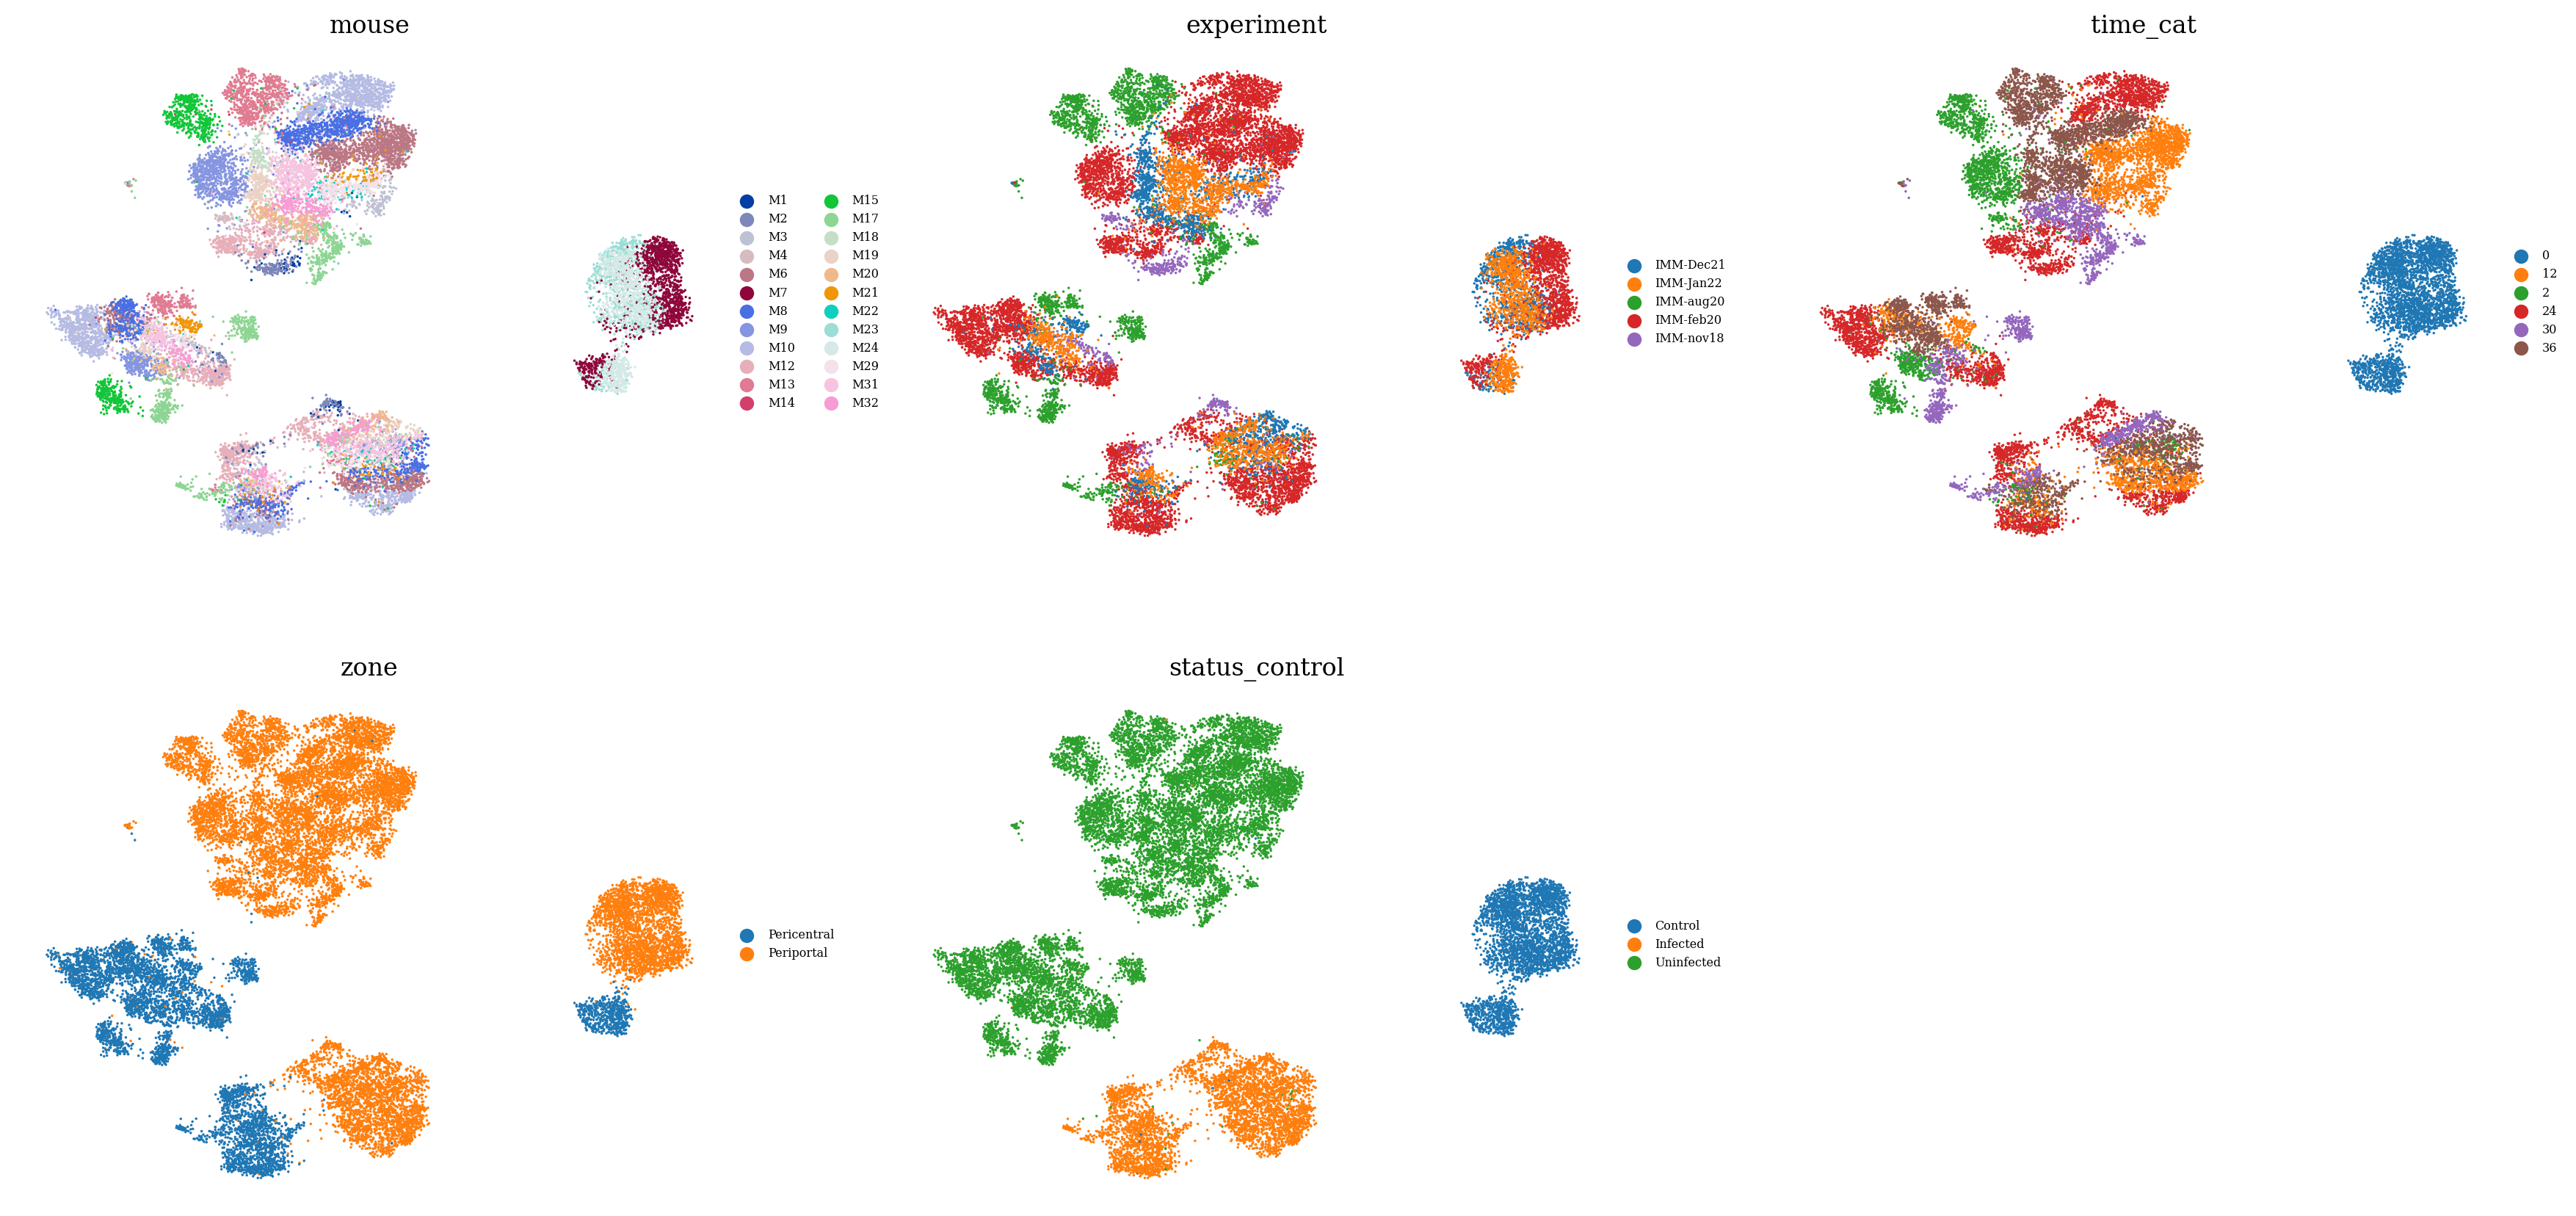

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

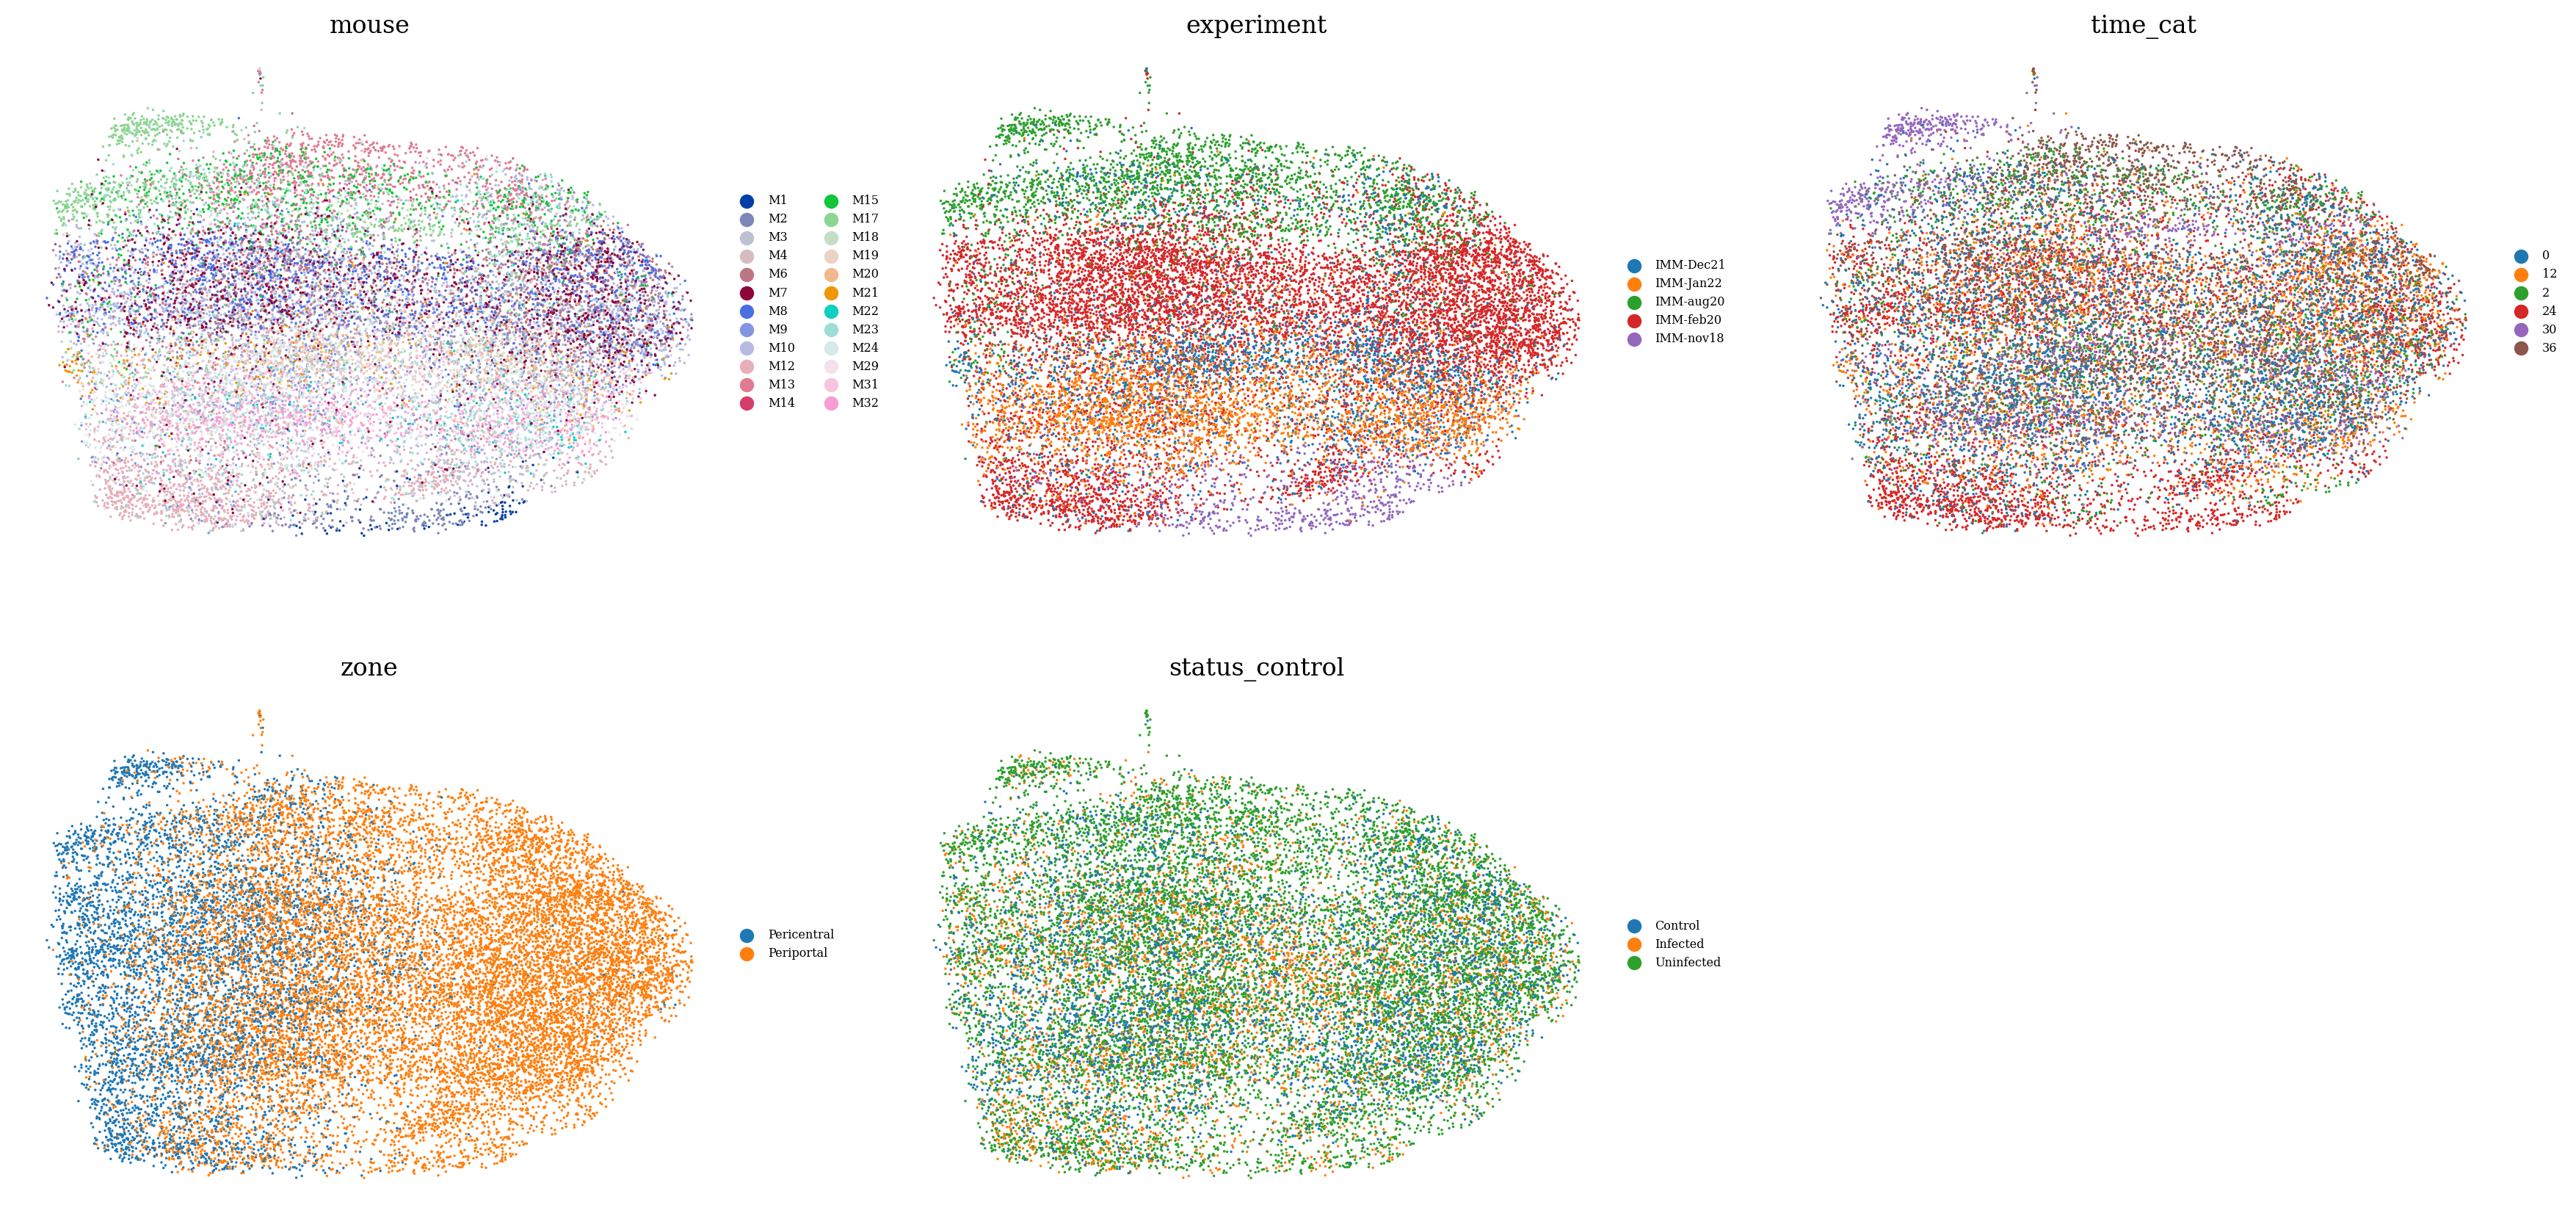

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  1%|          | 7/596 [00:00<00:08, 67.73it/s]

  5%|▌         | 30/596 [00:00<00:03, 159.97it/s]

  9%|▉         | 56/596 [00:00<00:02, 202.40it/s]

 14%|█▎        | 81/596 [00:00<00:02, 220.58it/s]

 18%|█▊        | 107/596 [00:00<00:02, 231.93it/s]

 22%|██▏       | 132/596 [00:00<00:01, 237.26it/s]

 26%|██▋       | 157/596 [00:00<00:01, 240.37it/s]

 31%|███       | 182/596 [00:00<00:01, 241.85it/s]

 35%|███▍      | 207/596 [00:00<00:01, 242.93it/s]

 39%|███▉      | 232/596 [00:01<00:01, 243.53it/s]

 43%|████▎     | 257/596 [00:01<00:01, 244.51it/s]

 47%|████▋     | 282/596 [00:01<00:01, 245.07it/s]

 52%|█████▏    | 307/596 [00:01<00:01, 245.83it/s]

 56%|█████▌    | 332/596 [00:01<00:01, 246.22it/s]

 60%|█████▉    | 357/596 [00:01<00:00, 245.97it/s]

 64%|██████▍   | 382/596 [00:01<00:00, 246.43it/s]

 68%|██████▊   | 407/596 [00:01<00:00, 246.21it/s]

 72%|███████▏  | 432/596 [00:01<00:00, 245.91it/s]

 77%|███████▋  | 457/596 [00:01<00:00, 246.18it/s]

 81%|████████  | 482/596 [00:02<00:00, 246.52it/s]

 85%|████████▌ | 507/596 [00:02<00:00, 245.96it/s]

 89%|████████▉ | 532/596 [00:02<00:00, 246.08it/s]

 93%|█████████▎| 557/596 [00:02<00:00, 245.63it/s]

 98%|█████████▊| 582/596 [00:02<00:00, 245.50it/s]

100%|██████████| 596/596 [00:02<00:00, 238.33it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

In [23]:
np.mean(r2s)

0.9817036395865806

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)